# Notebook 3 — Patches 32×32, Balanceamento e CNN (mini-MIAS)

Este notebook continua o pipeline após o **Notebook 2 (equalização)**.

## Objetivos
1. **Carregar** as imagens **equalizadas** (ou pré-processadas) e seus metadados;
2. **Extrair patches** de tamanho **32×32** com `stride` configurável, usando a máscara para evitar fundo;
3. **Atribuir rótulos** por `SEVERITY` (Normal/Benign/Malignant) a partir do `preprocess_manifest.csv`;
4. **Balancear** o dataset por classe usando **undersampling** até o tamanho da classe minoritária;
5. **Split por REFNUM** (70/15/15) para evitar *data leakage* entre patches da mesma imagem;
6. **Treinar uma CNN** simples (Keras) e **avaliar** com Accuracy, Precision, Recall, F1 e **matriz de confusão**.

### Pré-requisitos
- Notebook 1: `outputs_preproc/` existente (imagens e máscaras)
- Notebook 2: `outputs_eq/<modo>/` existente com as equalizações ou usar as pré-processadas
- `outputs_preproc/preprocess_manifest.csv` gerado


### Importações

In [14]:
from pathlib import Path
import numpy as np
import random
import tensorflow as tf
import os, re, glob
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter, defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from collections import defaultdict
from collections import Counter


### Configurações iniciais e utilidades

In [16]:
PATCH_SIZE = 32
STRIDE = 16
MASK_MIN_FRACTION = 0.50

RANDOM_SEED = 42
BATCH_SIZE = 64
EPOCHS = 25
LR = 5e-4

BASE_DIR = Path('.')
PREPROC_DIR = BASE_DIR / 'outputs_preproc'
PREPROC_IMG_DIR = PREPROC_DIR / 'images'
PREPROC_MSK_DIR = PREPROC_DIR / 'masks'
PREPROC_MANIFEST = PREPROC_DIR / 'preprocess_manifest.csv'

EQUALIZATION_MODE = 'clahe_test6'   
EQ_DIR = BASE_DIR / 'outputs_eq' / EQUALIZATION_MODE if EQUALIZATION_MODE else None

# Extração de patches
PATCH_SIZE = 32
STRIDE = 32   # 16 para overlaps
MASK_MIN_FRACTION = 0.6  # fração mínima de pixels da mama dentro do patch

# Split por REFNUM (evita vazamento)
SPLIT = {'train': 0.70, 'val': 0.15, 'test': 0.15}
RANDOM_SEED = 42

# Treino
BATCH_SIZE = 64
EPOCHS = 20
LR = 1e-3
EQ_DIR = BASE_DIR / 'outputs_eq' / EQUALIZATION_MODE if EQUALIZATION_MODE else None

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
print('Config OK:', {'PATCH_SIZE': PATCH_SIZE, 'STRIDE': STRIDE, 'MASK_MIN_FRACTION': MASK_MIN_FRACTION, 'LR': LR})

Config OK: {'PATCH_SIZE': 32, 'STRIDE': 32, 'MASK_MIN_FRACTION': 0.6, 'LR': 0.001}


#### Utilidades

In [17]:
def read_gray_float01(path: Path):
    import skimage.io as skio
    img = skio.imread(path)
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = img.astype(np.float32)
    if img.max() > 1:
        img /= 255.0
    return np.clip(img, 0.0, 1.0)

def extract_patches_from_image(img, msk, patch=32, stride=32, mask_min_fraction=0.6):
    H, W = img.shape
    patches = []
    for y in range(0, H - patch + 1, stride):
        for x in range(0, W - patch + 1, stride):
            roi = img[y:y+patch, x:x+patch]
            rmask = msk[y:y+patch, x:x+patch]
            if rmask.mean() >= mask_min_fraction:
                patches.append((roi, (y, x)))
    return patches

def clean_severity(v):
    import numpy as np
    if hasattr(v, 'iloc'):
        try:
            v = v.iloc[0]
        except Exception:
            v = str(v)
    if isinstance(v, (list, tuple, np.ndarray)):
        v = v[0] if len(v) else ''
    v = str(v).replace('\n', ' ').strip()
    vl = v.lower()
    if 'normal' in vl: return 'Normal'
    if 'benign' in vl: return 'Benign'
    if 'malig'  in vl: return 'Malignant'
    return v or 'Unknown'

def build_cnn_bn(input_shape=(32,32,1), n_classes=3, lr=1e-3):
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)
    m = tf.keras.Model(inputs, outputs)
    m.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return m

def bincount_named(y, le):
    import numpy as np
    if len(y) == 0:
        return {}
    bc = np.bincount(y, minlength=len(le.classes_))
    return {cls: int(bc[i]) for i, cls in enumerate(le.classes_)}


### 1) `df_img` → limpeza de rótulos

In [18]:
assert PREPROC_MANIFEST.is_file(), f"Manifest não encontrado: {PREPROC_MANIFEST}"
meta = pd.read_csv(PREPROC_MANIFEST)

# Ajusta REFNUM para minúsculas
meta['REFNUM'] = meta['REFNUM'].astype(str).str.lower()

# Seleciona apenas colunas relevantes
cols = ['REFNUM','output_img','output_mask','SEVERITY','DENSITY','CLASS','CLASS_GROUP']
for c in cols:
    if c not in meta.columns:
        meta[c] = np.nan
meta = meta[cols]

print('Linhas no manifest:', len(meta))
meta.head(3)

def eq_path_for_ref(refnum: str, mode: str):
    if not mode:
        return None
    # Saída do Notebook 2 salva como: <ref>_<modo>.png (onde <ref> é stem sem _preproc)
    # Ex.: mdb001_clahe_test6.png
    return (EQ_DIR / f"{refnum}_{mode}.png")

def build_records(meta_df: pd.DataFrame, mode: str):
    recs = []
    for _, row in meta_df.iterrows():
        ref = row['REFNUM']
        mask_path = Path(row['output_mask']) if isinstance(row['output_mask'], str) else None
        if mode:
            img_path = eq_path_for_ref(ref, mode)
        else:
            # usa a pré-processada
            img_path = Path(str(row['output_img']).replace('_preproc.png', '_preproc.png'))
        recs.append({
            'REFNUM': ref,
            'img_path': str(img_path) if img_path else None,
            'mask_path': str(mask_path) if mask_path else None,
            'SEVERITY': row['SEVERITY'],
            'DENSITY': row['DENSITY'],
            'CLASS': row['CLASS'],
            'CLASS_GROUP': row['CLASS_GROUP'],
        })
    df = pd.DataFrame(recs)
    # Mantém somente registros existentes em disco
    df = df[df['img_path'].apply(lambda p: Path(p).is_file())]
    df = df[df['mask_path'].apply(lambda p: Path(p).is_file())]
    return df

df_img = build_records(meta, EQUALIZATION_MODE)
print('Imagens utilizáveis:', len(df_img))
df_img.head(3)

assert 'df_img' in globals(), 'df_img não encontrado. Execute as células anteriores que constroem df_img.'
df_img = df_img.copy()
df_img['SEVERITY'] = df_img['SEVERITY'].apply(clean_severity).astype(str)
df_img.head(3)

Linhas no manifest: 644
Imagens utilizáveis: 644


,REFNUM,img_path,mask_path,SEVERITY,DENSITY,CLASS,CLASS_GROUP
0,mdb001,outputs_eq\clahe_test6\mdb001_clahe_test6.png,outputs_preproc\masks\mdb001_mask.png,Benign,B,CIRC,Masses
1,mdb001,outputs_eq\clahe_test6\mdb001_clahe_test6.png,outputs_preproc\masks\mdb001_mask.png,Benign,B,CIRC,Masses
2,mdb002,outputs_eq\clahe_test6\mdb002_clahe_test6.png,outputs_preproc\masks\mdb002_mask.png,Benign,B,CIRC,Masses


### 2) Reextração de patches (32×32, STRIDE=16, MASK_MIN_FRACTION=0.50)

In [19]:
records = []
for _, r in df_img.iterrows():
    img = read_gray_float01(Path(r['img_path']))
    msk = read_gray_float01(Path(r['mask_path']))
    msk = (msk > 0.5).astype(np.float32)
    pts = extract_patches_from_image(img, msk, patch=PATCH_SIZE, stride=STRIDE, mask_min_fraction=MASK_MIN_FRACTION)
    for roi, (yy, xx) in pts:
        records.append({'REFNUM': r['REFNUM'], 'SEVERITY': r['SEVERITY'], 'patch': roi.astype(np.float32)})

df_patches = pd.DataFrame(records)
print('Total de patches extraídos:', len(df_patches))
print(df_patches['SEVERITY'].value_counts(dropna=False))

Total de patches extraídos: 452326
SEVERITY
Normal       291920
Benign        89912
Malignant     70494
Name: count, dtype: int64


### 3) Split por REFNUM (70/15/15) + Balanceamento (undersampling)

In [ ]:
ref2label = df_patches.groupby('REFNUM')['SEVERITY'].agg(lambda s: s.iloc[0]).to_dict()
by_class_refs = defaultdict(list)
for ref, lab in ref2label.items():
    by_class_refs[str(lab)].append(ref)

train_refs, val_refs, test_refs = set(), set(), set()
rng = np.random.RandomState(42)
SPLIT = {'train': 0.70, 'val': 0.15, 'test': 0.15}
for lab, refs in by_class_refs.items():
    refs = sorted(refs)
    rng.shuffle(refs)
    n = len(refs)
    n_train = int(SPLIT['train'] * n)
    n_val = int(SPLIT['val'] * n)
    train_refs.update(refs[:n_train])
    val_refs.update(refs[n_train:n_train+n_val])
    test_refs.update(refs[n_train+n_val:])

def subset_by_refs(df, refs):
    return df[df['REFNUM'].isin(refs)].copy()

train_df = subset_by_refs(df_patches, train_refs)
val_df   = subset_by_refs(df_patches, val_refs)
test_df  = subset_by_refs(df_patches, test_refs)

print('Patches por split (ANTES do balanceamento):')
print('train:', train_df['SEVERITY'].value_counts(dropna=False).to_dict())
print('val  :', val_df['SEVERITY'].value_counts(dropna=False).to_dict())
print('test :', test_df['SEVERITY'].value_counts(dropna=False).to_dict())

def undersample_to_min(df, label_col='SEVERITY', seed=42):
    counts = df[label_col].value_counts()
    if len(counts) == 0:
        return df
    min_count = counts.min()
    parts = [df[df[label_col]==lab].sample(min_count, random_state=seed) for lab in counts.index]
    out = pd.concat(parts, axis=0).sample(frac=1.0, random_state=seed).reset_index(drop=True)
    return out

train_df_bal = undersample_to_min(train_df)
val_df_bal   = undersample_to_min(val_df)
test_df_bal  = undersample_to_min(test_df)

print('\nPatches por split (APÓS balanceamento):')
print('train:', train_df_bal['SEVERITY'].value_counts(dropna=False).to_dict())
print('val  :', val_df_bal['SEVERITY'].value_counts(dropna=False).to_dict())
print('test :', test_df_bal['SEVERITY'].value_counts(dropna=False).to_dict())

Patches por split (ANTES do balanceamento):
train: {'Normal': 202326, 'Benign': 62738, 'Malignant': 48382}
val  : {'Normal': 44486, 'Benign': 11982, 'Malignant': 10174}
test : {'Normal': 45108, 'Benign': 15192, 'Malignant': 11938}

Patches por split (APÓS balanceamento):
train: {'Malignant': 48382, 'Normal': 48382, 'Benign': 48382}
val  : {'Benign': 10174, 'Normal': 10174, 'Malignant': 10174}
test : {'Malignant': 11938, 'Benign': 11938, 'Normal': 11938}


### 4) Encoder/Arrays + Diagnósticos

In [9]:
print('== CONTAGEM POR CLASSE (DataFrame, ANTES do encoder) ==')
for name, df_ in [('train_df_bal', train_df_bal), ('val_df_bal', val_df_bal), ('test_df_bal', test_df_bal)]:
    print(f"\n{name}: {len(df_)} patches")
    print(df_['SEVERITY'].value_counts(dropna=False))
    print('Classes únicas:', sorted(df_['SEVERITY'].astype(str).unique().tolist()))

le = LabelEncoder()
le.fit(train_df_bal['SEVERITY'].astype(str).values)
n_classes = len(le.classes_)
print('\nClasses (ordem do encoder):', list(le.classes_))

def df_to_xy(df):
    if len(df) == 0:
        return (np.empty((0, PATCH_SIZE, PATCH_SIZE, 1), dtype=np.float32), np.empty((0,), dtype=np.int64))
    cats = pd.Categorical(df['SEVERITY'].astype(str), categories=list(le.classes_))
    y_codes = cats.codes
    mask = y_codes != -1
    if mask.sum() == 0:
        return (np.empty((0, PATCH_SIZE, PATCH_SIZE, 1), dtype=np.float32), np.empty((0,), dtype=np.int64))
    X = np.stack(df.loc[mask, 'patch'].values).astype(np.float32)
    X = X[..., np.newaxis]
    y = y_codes[mask].astype(np.int64)
    return X, y

X_train, y_train = df_to_xy(train_df_bal)
X_val,   y_val   = df_to_xy(val_df_bal)
X_test,  y_test  = df_to_xy(test_df_bal)

def bincount_named(y, le):
    if len(y) == 0:
        return {}
    bc = np.bincount(y, minlength=len(le.classes_))
    return {cls: int(bc[i]) for i, cls in enumerate(le.classes_)}

print('\n== CONTAGEM POR CLASSE (arrays, DEPOIS do encoder) ==')
print('y_train:', bincount_named(y_train, le))
print('y_val  :', bincount_named(y_val,   le))
print('y_test :', bincount_named(y_test,  le))

assert len(np.unique(y_train)) == n_classes, f"Alguma classe ausente no treino: {np.unique(y_train)} de {n_classes}"
print('\nShapes:', X_train.shape, X_val.shape, X_test.shape)

== CONTAGEM POR CLASSE (DataFrame, ANTES do encoder) ==

train_df_bal: 145146 patches
SEVERITY
Malignant    48382
Normal       48382
Benign       48382
Name: count, dtype: int64
Classes únicas: ['Benign', 'Malignant', 'Normal']

val_df_bal: 30522 patches
SEVERITY
Benign       10174
Normal       10174
Malignant    10174
Name: count, dtype: int64
Classes únicas: ['Benign', 'Malignant', 'Normal']

test_df_bal: 35814 patches
SEVERITY
Malignant    11938
Benign       11938
Normal       11938
Name: count, dtype: int64
Classes únicas: ['Benign', 'Malignant', 'Normal']

Classes (ordem do encoder): ['Benign', 'Malignant', 'Normal']

== CONTAGEM POR CLASSE (arrays, DEPOIS do encoder) ==
y_train: {'Benign': 48382, 'Malignant': 48382, 'Normal': 48382}
y_val  : {'Benign': 10174, 'Malignant': 10174, 'Normal': 10174}
y_test : {'Benign': 11938, 'Malignant': 11938, 'Normal': 11938}

Shapes: (145146, 32, 32, 1) (30522, 32, 32, 1) (35814, 32, 32, 1)


### 5) Treino com `class_weight` + CNN com BN/Dropout

In [ ]:
cnt = Counter(y_train)
total = sum(cnt.values())
class_weight = {i: total / (n_classes * cnt[i]) for i in range(n_classes)}
print('class_weight:', class_weight)

model = build_cnn_bn(input_shape=(PATCH_SIZE, PATCH_SIZE, 1), n_classes=n_classes, lr=LR)
model.summary()

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=1
)


class_weight: {0: 1.0, 1: 1.0, 2: 1.0}


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,143,171 (4.36 MB)

 Trainable params: 1,142,467 (4.36 MB)

 Non-trainable params: 704 (2.75 KB)

Epoch 1/20
2268/2268 ━━━━━━━━━━━━━━━━━━━━ 103s 44ms/step - accuracy: 0.3726 - loss: 1.1026 - val_accuracy: 0.3305 - val_loss: 1.1903 - learning_rate: 0.0010
Epoch 2/20
2268/2268 ━━━━━━━━━━━━━━━━━━━━ 102s 45ms/step - accuracy: 0.4235 - loss: 1.0633 - val_accuracy: 0.3323 - val_loss: 1.3167 - learning_rate: 0.0010
Epoch 3/20
2268/2268 ━━━━━━━━━━━━━━━━━━━━ 105s 46ms/step - accuracy: 0.4971 - loss: 0.9882 - val_accuracy: 0.3262 - val_loss: 1.3465 - learning_rate: 0.0010
Epoch 4/20
2268/2268 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5722 - loss: 0.8879
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2268/2268 ━━━━━━━━━━━━━━━━━━━━ 108s 47ms/step - accuracy: 0.5975 - loss: 0.8469 - val_accuracy: 0.4021 - val_loss: 2.0624 - learning_rate: 0.0010
Epoch 5/20
2268/2268 ━━━━━━━━━━━━━━━━━━━━ 106s 47ms/step - accuracy: 0.7009 - loss: 0.6674 - val_accuracy: 0.3232 - val_loss: 2.3849 - learning_rate: 5.0000e-04
Epoch 6/20
2268/2268 ━━━━━━━━━━━━━━━━━━━━ 108s 47ms/step 

### 6) Avaliação — Relatório e Matriz de Confusão

560/560 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
Relatório de classificação (por patches):
              precision    recall  f1-score   support

      Benign       0.36      0.48      0.41     11938
   Malignant       0.36      0.58      0.44     11938
      Normal       0.30      0.01      0.02     11938

    accuracy                           0.36     35814
   macro avg       0.34      0.36      0.29     35814
weighted avg       0.34      0.36      0.29     35814

Matriz de confusão (ordem dos rótulos = encoder):
[[5754 6007  177]
 [4958 6884   96]
 [5459 6362  117]]


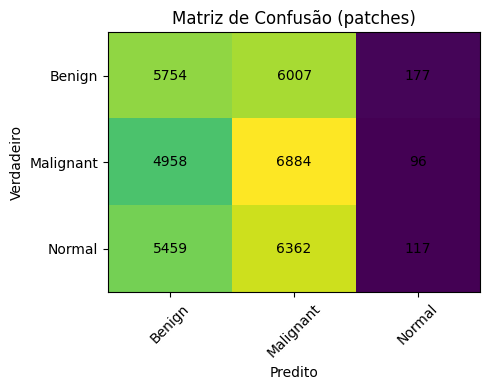

In [11]:
all_labels = np.arange(n_classes)
all_names  = list(le.classes_)
y_pred = model.predict(X_test, batch_size=BATCH_SIZE) if len(X_test) else np.empty((0, n_classes))
y_hat  = np.argmax(y_pred, axis=1) if len(X_test) else np.array([], dtype=int)

print('Relatório de classificação (por patches):')
print(classification_report(y_test, y_hat, labels=all_labels, target_names=all_names, zero_division=0))

cm = confusion_matrix(y_test, y_hat, labels=all_labels)
print('Matriz de confusão (ordem dos rótulos = encoder):')
print(cm)

plt.figure(figsize=(5,4))
plt.imshow(cm, aspect='auto')
plt.title('Matriz de Confusão (patches)')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.xticks(ticks=all_labels, labels=all_names, rotation=45)
plt.yticks(ticks=all_labels, labels=all_names)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center')
plt.tight_layout()
plt.show()


# Interpretação dos resultados (classificação por *patches*)

## Métricas principais

- **Accuracy = 0,36 (36%)**  
  Proporção total de acertos em 35.814 *patches*. O modelo acerta pouco acima do acaso (3 classes → 33%), indicando que ainda não separa bem os padrões das classes.

- **Support**  
  Número de amostras por classe no conjunto de teste (aqui, balanceadas por undersampling):  
  Benign = 11.938 | Malignant = 11.938 | Normal = 11.938.

- **Precision (Precisão)**: entre as predições de uma classe, quantas estão corretas?
  - **Benign = 0,36** → de cada 100 *patches* previstos como “Benign”, ~36 são realmente “Benign”.
  - **Malignant = 0,36** → de cada 100 previstos como “Malignant”, ~36 são realmente “Malignant”.
  - **Normal = 0,30** → de cada 100 previstos como “Normal”, ~30 são realmente “Normal”.
  
- **Recall (Revocação/Sensibilidade)**: entre os *patches* realmente da classe, quantos o modelo recupera?
  - **Benign = 0,48** → recupera 48% dos *patches* benignos.
  - **Malignant = 0,58** → recupera 58% dos malignos (melhor classe do modelo).
  - **Normal = 0,01** → praticamente **não recupera** *patches* normais (forte fraqueza).

- **F1-score** (harmônica de precision e recall):  
  - **Benign = 0,41**, **Malignant = 0,44**, **Normal = 0,02** (muito baixo, puxado pelo recall ≈ 0).

- **Macro avg** (média simples entre classes):  
  Precision = 0,34 | Recall = 0,36 | F1 = 0,29 → reflete o desempenho ruim em “Normal”.

- **Weighted avg** (média ponderada pelo support):  
  Próxima à macro porque as classes têm support igual; também ≈ 0,34–0,36–0,29.

---

### Leitura por classe

- **Benign (linha 1):**  
  5.754 acertos (Benign→Benign) e 6.007 erros como **Malignant**. O modelo confunde muito “Benign” com “Malignant”.

- **Malignant (linha 2):**  
  6.884 acertos (melhor linha) e 4.958 erros como **Benign**. É a classe mais “recuperada” (recall 0,58), mas ainda com muita confusão com “Benign”.

- **Normal (linha 3):**  
  Apenas **117 acertos** (Normal→Normal), **5.459** confundidos com **Benign** e **6.362** com **Malignant**.  
  → **Principal gargalo:** o modelo quase nunca reconhece *patches* realmente “Normal”.

---

## O que esses números nos dizem
1. **Tendência a prever “lesão”** (Benign/Malignant) para quase tudo: “Normal” raramente é previsto (recall 1%).  
2. **Benign × Malignant**: há **forte confusão mútua**; o modelo captura malignos com recall razoável (0,58), mas sua precisão ainda é baixa (0,36).
3. **Acima do acaso, mas pouco**: accuracy 0,36 sugere que o modelo aprendeu algum padrão, porém ainda insuficiente para separações clínicas úteis no nível de *patch*.

---